# Transient Arctic modeling

## Model configuration

<img src='image/fullxml.png' width='768' height='200' alt='transient configuration' align='center' />

## Column model

<img src='image/column.png' width='130' height='360' alt='column mesh' align='left' />  

|Soil layer                                                        |Moss|Peat|Mineral|
|:-----------------------------------------------------------------|:--:|:--:|:-----:|
|Thickness                                                         |2cm |8cm |49.9m  |
|Porosity                                                          |0.9 |0.876|0.596 |
|Permeability ($\mathrm{m}^2$)                                     |1.7e-11|9.38e-12|6e-13|
|Van Genuchten $\alpha$ (Pa$^{-1}$)                                |2.3e-3|9.5e-4|3.3e-4|
|Van Genuchten n                                                   |1.38|1.44|1.33|
|Residual saturation                                               |0.056|0.388|0.334|
|Thermal conductivity, unfrozen ($\mathrm{Wm}^{-1}\mathrm{K}^{-1}$)|0.446|0.427|0.788|
|Thermal conductivity, dry ($\mathrm{Wm}^{-1}\mathrm{K}^{-1}$)     |0.024|0.025|0.104|
||||(Atchley el at., 2015)|
|Get forcing data is from Daymet (https://daymet.ornl.gov/single-pixel/api) by ATS tool **daymet_to_ats.py**||||

## Model setup – initialization

freeze.xml
* The purpose is to freeze a soil column from bottom to top to obtain an initial frozen soil domain.
* The freeze-up model has the same configuration with demo 1.
* Initial water table depth = -5.78m
* Run for a long time to reach steady state (1000 years)
* Obtain the final pressure and temperature profile using ATS tool **column_data.py**

## Model setup – transient 

* cycle driver
  - Basic configuration
  - Run for 1 year
* subsurface flow
  - Initial condition: from freezeup
  - Boundary condition: J$_\mathrm{w}$ = 0 
* surface flow
  - Initial condition: from subsurface
  - Boundary condition: outlet at surface; if hillslope, would be possible define the lower side as outlet
* subsurface energy
  - Initial condition: from freezeup
  - Boundary condition: T$_\mathrm{bottom}$ = -10˚C
* surface energy
  - Initial condition: from subsurface
  - Boundary condition: J$_\mathrm{e}$ = 0
* SEB
  - Initial condition: snow depth, could be from the last step of spinup

## Observation

We add **observation** in this model input file.
It is used for collecting some specific modeled results (variables/parameters) 
probably at some specific locations with time. Locations are defined in **region**.

# Model observation

In [1]:
%matplotlib inline
import sys, os
sys.path.append(os.path.join(os.environ['ATS_SRC_DIR'],'tools', 'utils'))
sys.path.append('py_script')
import obsRead
import numpy as np
from matplotlib import rcParams
import matplotlib.pyplot as plt

## def (process modeled results)

In [2]:
def modeled(directory):
    obs_dir = os.path.join(directory, 'observation.dat')
    skiprows, header = obsRead.read_file(obs_dir)
    obs_data = np.loadtxt(obs_dir, delimiter=' ', skiprows=skiprows)
        
    time = np.arange(0,366)
    
    wc_surf,evaporation,thaw_depth,\
    T_surf,T_subp10,T_subp40,T_subp100,\
    sl_subp1,sl_subp3,sl_subp5,sl_subp10,\
    si_subp1,si_subp3,si_subp5,si_subp10\
    = (np.zeros((1,len(time))) for i in range(15))

    wc_surf     = obs_data[:,header.index('surface water content [mol]')]/55500*1000
    evaporation = obs_data[:,header.index('evaporation rate [m s^-1]')]*86400*1000
    thaw_depth  = obs_data[:,header.index('thaw depth [m]')]*100
        
    T_surf    = obs_data[:,header.index('surface temperature [K]')]
    T_subp10  = obs_data[:,header.index('point 0.1 temperature [K]')]
    T_subp40  = obs_data[:,header.index('point 0.4 temperature [K]')]
    T_subp100 = obs_data[:,header.index('point 1 temperature [K]')]
    
    sl_subp1  = obs_data[:,header.index('point 0.01 saturation liquid')]
    sl_subp3  = obs_data[:,header.index('point 0.03 saturation liquid')]
    sl_subp5  = obs_data[:,header.index('point 0.05 saturation liquid')]
    sl_subp10 = obs_data[:,header.index('point 0.1 saturation liquid')]
       
    si_subp1  = obs_data[:,header.index('point 0.01 saturation ice')]
    si_subp3  = obs_data[:,header.index('point 0.03 saturation ice')]
    si_subp5  = obs_data[:,header.index('point 0.05 saturation ice')]
    si_subp10 = obs_data[:,header.index('point 0.1 saturation ice')]
        
    # simulated results set
    simset = {}
    simset['surface water content (1e-3 m3)'] = wc_surf
    simset['evaporation (mm/d)']    = evaporation
    simset['thaw depth (cm)']       = thaw_depth
    simset['temperature (K)']       = [T_surf,T_subp10,T_subp40,T_subp100]
    simset['saturation liquid']     = [sl_subp1,sl_subp3,sl_subp5,sl_subp10]
    simset['saturation ice']        = [si_subp1,si_subp3,si_subp5,si_subp10]

    return simset

## def (plot solutions)

Variales to plot include:  
(1) surface water content ($\mathrm{m}^3$)  
(2) evaporation (mm/d)    
(3) thaw depth (cm)  
(4) temperature (K)   
(5) saturation liquid  
(6) saturation ice

In [3]:
def plot(simset,var,axs,label,fontsize=12):
    rcParams['xtick.labelsize'] = fontsize
    rcParams['ytick.labelsize'] = fontsize
    rcParams['axes.labelsize'] = fontsize
    
    time = np.arange(0,366)
    
    if type(simset[var]) is not list:
        axs.plot(time,simset[var],'k*')
    
    else:
        cmap = plt.get_cmap('viridis')
        colors = cmap(np.linspace(0,1,len(simset[var])))
        for i in range(4):
            axs.plot(time,simset[var][i],color=colors[i],label=label[i])
        axs.legend()
    
    axs.set_xticks(range(0,365,90))
    axs.set_xlabel('Time (day)',fontsize=fontsize)
    axs.set_ylabel(var.capitalize(),fontsize=fontsize)

## Solutions

In [4]:
directory = "transient"
simset = modeled(directory)

## Plot solutions

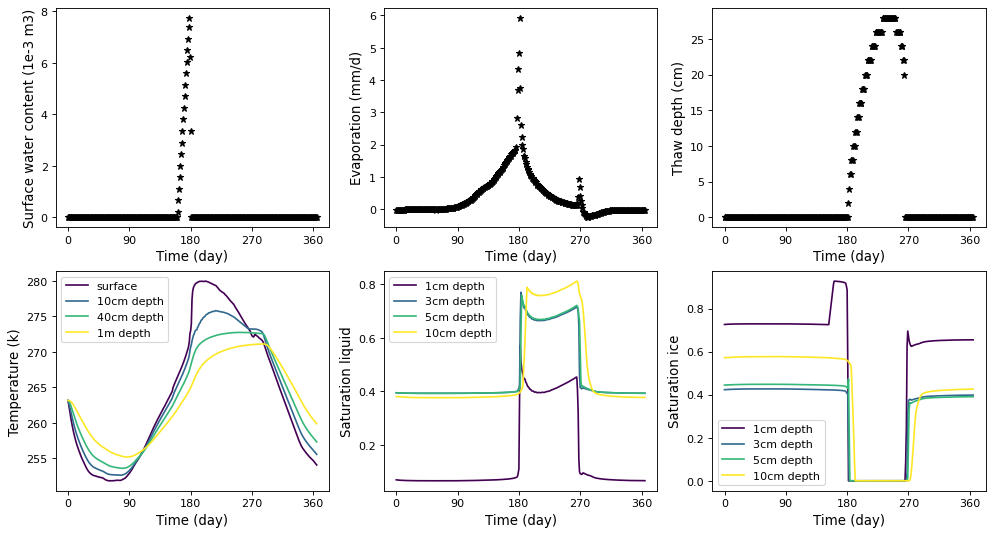

In [5]:
nrows, ncols = 2,3
figl, figw = 15,8
fig, axs = plt.subplots(nrows,ncols,figsize=(figl,figw),dpi=80)
keys = list(simset.keys())
for i in range(ncols):
    plot(simset,keys[i],axs[0][i],label=None)

labels = [['surface','10cm depth','40cm depth','1m depth'],
          ['1cm depth','3cm depth','5cm depth','10cm depth'],
          ['1cm depth','3cm depth','5cm depth','10cm depth']]

for i in range(ncols):
    plot(simset,keys[i+3],axs[1][i],labels[i])

plt.subplots_adjust(wspace=0.2,hspace=0.2)

## VisIt visulization

Evolution of ice saturation  

<img src="image/sat_ice.gif" width = "800" height = "1240" alt='s_ice profile' align='center' >